# Assignment
Analyze and compare the performance of a standard ResNet model and a ResNet model with an attention module (CBAM) for image classification.
- Train both models on a given dataset.
- Compare results between the standard ResNet and the attention-enhanced ResNet.
- Discuss findings and provide conclusions on whether the attention mechanism improves classification performance.

In [ ]:
# # Download the dataset
import gdown
import os

file_id = "1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T"

gdown.download(f"https://drive.google.com/uc?id={file_id}", "cat_and_dog.zip", quiet=False)

os.system("unzip -q cat_and_dog.zip -d cat_and_dog_dataset")

print("Dataset downloaded and extracted")


Downloading...
From (original): https://drive.google.com/uc?id=1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T
From (redirected): https://drive.google.com/uc?id=1uxav6g0wBXfQ-dUGBC5ePQfBeDjFip2T&confirm=t&uuid=3711dbe1-a85f-423b-9666-582593f7058b
To: /content/cat_and_dog.zip
100%|██████████| 67.6M/67.6M [00:02<00:00, 22.7MB/s]


Dataset downloaded and extracted


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

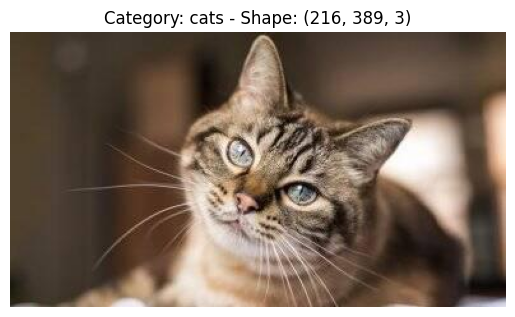

Image shape: (216, 389, 3)


In [ ]:
# Visualize an input cat image
dataset_root = "cat_and_dog_dataset"
train_dir = os.path.join(dataset_root, "train")

category = 'cats'
image_dir = os.path.join(train_dir, category)

assert os.path.exists(image_dir), f"Error: Category directory '{image_dir}' does not exist!"
assert len(os.listdir(image_dir)) > 0, f"Error: No images found in '{image_dir}'!"

image_name = os.listdir(image_dir)[1]
image_path = os.path.join(image_dir, image_name)

image = Image.open(image_path).convert("RGB")
image_array = np.array(image)

plt.imshow(image)
plt.title(f"Category: {category} - Shape: {image_array.shape}")
plt.axis('off')
plt.show()

print(f"Image shape: {image_array.shape}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

In [ ]:
# Define networks
class Network(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Network, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0])

        self.layer2 = self._make_layer(block, 128, num_blocks[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

##ResNet

In [ ]:
# Define a residual block with skip connection
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

##Attention

In [ ]:
# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)
        #return self.sigmoid(out) * x


In [ ]:
# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x



In [ ]:
# Define the CBAM-like Attention Module
class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]

        return x

In [ ]:
# Define a residual block with skip connection
class ResidualWithCBAM(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualWithCBAM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.cbam = CBAMAttention(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.cbam(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

##Train and Evaluate

In [ ]:
# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Use only 1/10 of the data
train_indices = torch.randperm(len(trainset))[:len(trainset) // 10]
trainset = torch.utils.data.Subset(trainset, train_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Use only 1/10 of the data
test_indices = torch.randperm(len(testset))[:len(testset) // 10]
testset = torch.utils.data.Subset(testset, test_indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train(model, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}')

    return train_losses

In [ ]:
# Evaluation function
def evaluate(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [ ]:
# Create models
residual_network = Network(ResidualBlock, [2, 2, 2, 2])
residual_attention = Network(ResidualWithCBAM, [2, 2, 2, 2])


# Train both networks
print("\nTraining Residual Network:")
residual_losses = train(residual_network)

print("Training CBAM Network:")
attention_losses = train(residual_attention)


Training Residual Network:
Epoch 1, Loss: 1.955
Epoch 2, Loss: 1.763
Epoch 3, Loss: 1.659
Epoch 4, Loss: 1.591
Epoch 5, Loss: 1.497
Epoch 6, Loss: 1.441
Epoch 7, Loss: 1.383
Epoch 8, Loss: 1.307
Epoch 9, Loss: 1.281
Epoch 10, Loss: 1.234
Training CBAM Network:
Epoch 1, Loss: 1.846
Epoch 2, Loss: 1.632
Epoch 3, Loss: 1.493
Epoch 4, Loss: 1.340
Epoch 5, Loss: 1.243
Epoch 6, Loss: 1.147
Epoch 7, Loss: 1.065
Epoch 8, Loss: 0.992
Epoch 9, Loss: 0.925
Epoch 10, Loss: 0.830


In [ ]:
accuracy_resnet = evaluate(residual_network)
accuracy_resnet_cbam = evaluate(residual_attention)

Test Accuracy: 47.30%
Test Accuracy: 55.50%



Accuracy of ResNet is: 47.3%
Accuracy of ResNet-CBAM is: 55.5%
The result show loss of each model normal ResNet and ResNet with CBAM
CBAM accuracy more than normal ResNet loss less than normal ResNet
that mean when we add attention mechanism it can improve performance of model immediately!!!!!!



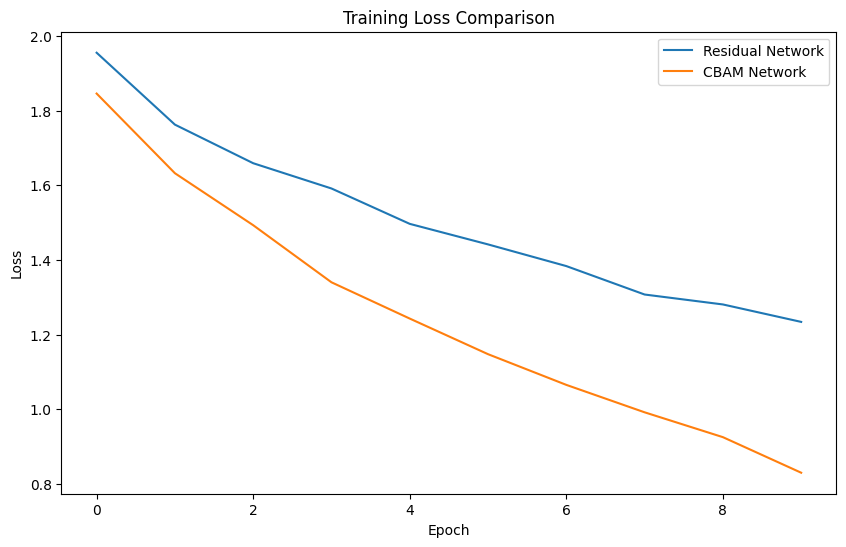

In [ ]:
# Plot training losses
print(f"""
Accuracy of ResNet is: {accuracy_resnet}%
Accuracy of ResNet-CBAM is: {accuracy_resnet_cbam}%
The result show loss of each model normal ResNet and ResNet with CBAM
CBAM accuracy more than normal ResNet loss less than normal ResNet
that mean when we add attention mechanism it can improve performance of model immediately!!!!!!
""")
plt.figure(figsize=(10, 6))
plt.plot(residual_losses, label='Residual Network')
plt.plot(attention_losses, label='CBAM Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
